Reset

In [3]:
# %reset -f

Imports

In [6]:
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics

AttributeError: Module 'scipy' has no attribute '_lib'

Initialising dictionary for statistics

In [ ]:
statistics_dict = {}

Functions

In [ ]:
def load_data(path, metadata, file_names):
    all_metadata = pd.read_csv(
        os.path.join(path, f"{metadata}.csv"),
        index_col="index",
        encoding="utf8",
        sep=";",
    )

    metadata = list(
        all_metadata[
            ((all_metadata["include_in_model"] == True))
            & (all_metadata["exclude_from_model"] == False)
        ].index
    )

    raw_reads_df = pd.DataFrame()
    for file in file_names:
        temp_df = pd.read_csv(
            os.path.join(path, f"{file}.csv"), encoding="utf8", index_col="gene"
        )
        raw_reads_df = raw_reads_df.join(temp_df, how="right")

    # raw_reads_df.reset_index(inplace=True, drop=False)

    # Makes sample names uniform
    new_columns = ("&").join(list(raw_reads_df.columns))
    new_columns = new_columns.replace("control", "IMDM")
    new_columns = new_columns.replace("CL307", "CL-307")
    new_columns = new_columns.replace("Albu", "AH1252")
    new_columns = new_columns.replace("cAlb", "AH1397")
    new_columns = new_columns.replace("Alb2", "AH1405")
    new_columns = new_columns.replace("LPS_PGN", "LPS-PGN")
    new_columns = new_columns.replace("LPS_R848", "LPS-R848")
    new_columns = new_columns.replace("Pam3_PGN", "Pam3-PGN")
    new_columns = new_columns.replace("Pam3_R848", "Pam3-R848")
    new_columns = new_columns.replace("PAM3", "Pam3")
    new_columns = new_columns.replace("Fla-ST", "Fla-St")
    new_columns = new_columns.replace("TL8", "TL8-506")
    new_columns = new_columns.replace("CL8", "TL8-506")

    new_columns = new_columns.split("&")
    raw_reads_df.columns = new_columns

    included_raw_reads = raw_reads_df[metadata].copy()
    # included_raw_reads["gene"] = raw_reads_df["gene"]
    # sample_name_list = get_pyrogen_name(set(included_raw_reads.columns[:-1]))
    # print("current samples:", list(set(sample_name_list)))

    # return raw_reads_df[metadata].copy()
    return included_raw_reads


def filter_out_lower_than_10_reads(counts):
    # Calculate the mean count for each gene (row)
    mean_counts = counts.mean(axis=1)

    # Filter out rows where mean count is greater than 10
    filtered = counts[mean_counts >= 10]

    return filtered


def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


def get_pyrogen_name(sample_name_list):
    output = []
    for sample in sample_name_list:
        output.append(sample.split("_")[1])
    return output


def raw_to_rpm(DataFrame):
    outputDF = pd.DataFrame()
    for sample in DataFrame.columns:
        total_reads = DataFrame[sample].sum()
        outputDF[sample] = DataFrame[sample].apply(
            lambda x: (x / total_reads) * 1000000
        )
    return outputDF


def plot_PCA(data, title):
    # determines samplenames
    hue = []
    style = []
    for sample in data.columns:
        sample = sample.split("_")
        hue.append(sample[1])
        style.append(sample[0])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data.T)
    output_df = pd.DataFrame(
        principal_components, columns=["PC0", "PC1"], index=data.columns
    )
    loadings = pd.DataFrame(
        pca.components_.transpose(), columns=["PC0", "PC1"], index=data.index
    )

    a = sns.scatterplot("PC0", "PC1", data=output_df, hue=hue, style=style)

    a.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
    a.set_title(title)
    print(pca.explained_variance_ratio_)
    return ()


# Accuracy: (True Positive + True Negative) / Total Predictions
# Precision: True Positive / (True Positive + False Positive)
# Recall: True Positive / (True Positive + False Negative)
# Specificity: True Negative / (True Negative + False Positive)
# F-score: 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [ ]:
file_name_list = [
    "BA034_raw_reads",
    "BA044_raw_reads",
    "BA051_raw_reads",
    "BA061_raw_reads",
    "BA064_raw_reads",
]

# loads all seq datasets
path = "~/MATseq/library/ML_models/dimensionlity reduction/support_files"


# loads metadata
train_set = load_data(path=path, metadata="all_metadata", file_names=file_name_list)

current samples: ['R848', 'PGN', 'Fla-PA', 'IMDM', 'LTA', 'LPS', 'Pam3', 'CRX-527', 'CL-307']


DESeq2 normalisation and filtration of more than 10 reads mean per gene, then zscore standardization

In [5]:
from scipy.stats import zscore as zscore

norm_train_set = to_normalize_DESeq2_style(train_set)
norm_filt_train_set = filter_out_lower_than_10_reads(norm_train_set)
z_train_set = zscore(norm_filt_train_set)
z_unf_train_set = zscore(norm_train_set)

AttributeError: Module 'scipy' has no attribute '_lib'

Training the model

In [14]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

y = pd.Series(real_labels, index=z_train_set.T.index)
X = z_train_set.T

# Define the best parameters
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}

# Create the MLPClassifier with the best parameters
mlpc = MLPClassifier(**params)

# # Fit the classifier to your data (X_train and y_train)
# mlpc.fit(X, y)

Checking perfromace of the trained model

In [15]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

y = pd.Series(real_labels, index=z_train_set.T.index)
X = z_train_set.T


loo = LeaveOneOut()
predicted_labels = []

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the MLPC classifier
    model = mlpc
    model.fit(X_train, y_train)

    # Make predictions on the test fold
    y_pred = model.predict(X_test)
    predicted_labels.append(y_pred[0])  # Append the predicted label for this fold

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TE

In [20]:
name = "MLPC"
mlps_performance = evaluate_model(name, real_labels, predicted_labels)

Model: MLPC reduced dimensions
Accuracy: 0.96
Precision: 0.9753086419753088
Recall: 0.9259259259259258
Specificity: 0.9259259259259258
F1 Score: 0.9305555555555556
Confusion Matrix: [[6 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0]
 [0 0 1 0 2 0 0 0 0]
 [0 0 0 8 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 5]]
Model: MLPC
Accuracy: 0.96
Precision: 0.9753086419753088
Recall: 0.9259259259259258
Specificity: 0.9259259259259258
F1 Score: 0.9305555555555556
Confusion Matrix: [[6 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0]
 [0 0 1 0 2 0 0 0 0]
 [0 0 0 8 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 5]]


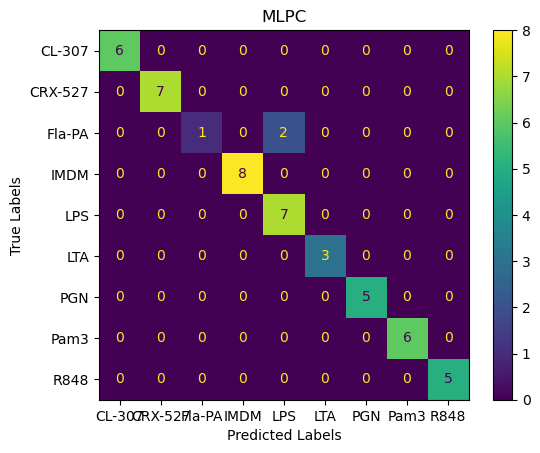

In [21]:
for model, model_stats in statistics_dict.items():
    print(f"Model: {model}")
    for metric, value in model_stats.items():
        print(f"{metric}: {value}")

    # class_labels = y.unique()
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=statistics_dict[model]["Confusion Matrix"],
        display_labels=mlpc.classes_,
    )

cm_display.plot()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"{model}")
plt.show()

In [97]:
z_unf_train_set

,BA063_Pam3_18,BA063_Pam3_17,BA063_Pam3_16,BA063_LPS_5,BA063_IMDM_3,BA063_IMDM_1,BA063_CRX-527_27,BA063_CRX-527_26,BA063_CRX-527_25,BA060_IMDM_01,...,BA029_CL-307_22,BA028_R848_16,BA028_R848_15,BA028_R848_13,BA028_Pam3_11,BA028_Pam3_10,BA028_Pam3_09,BA028_LPS_07,BA028_LPS_05,BA028_IMDM_02
0,-0.174963,-0.173863,-0.178164,-0.199433,-0.213177,-0.216978,-0.193054,-0.193961,-0.197209,-0.221650,...,-0.195269,-0.166579,-0.167783,-0.173500,-0.156508,-0.160017,-0.160158,-0.182495,-0.192504,-0.204663
1,-0.100949,-0.095820,-0.105544,-0.100157,-0.129406,-0.133803,-0.098287,-0.110185,-0.115360,-0.129649,...,-0.079046,-0.093888,-0.093875,-0.090151,-0.102022,-0.086478,-0.099564,-0.105672,-0.114025,-0.145132
2,-0.148296,-0.147097,-0.157956,-0.166056,-0.174411,-0.158116,-0.167169,-0.158502,-0.166348,-0.174152,...,-0.151686,-0.143531,-0.153570,-0.137614,-0.134481,-0.142927,-0.129310,-0.147883,-0.163966,-0.166048
3,-0.175507,-0.173863,-0.178164,-0.199433,-0.213177,-0.216978,-0.193054,-0.194351,-0.197209,-0.221650,...,-0.195269,-0.167761,-0.167783,-0.173500,-0.156508,-0.160017,-0.160158,-0.182495,-0.192504,-0.204663
4,-0.025304,-0.023975,-0.029766,-0.008868,-0.042071,-0.010959,-0.012294,-0.036151,-0.054979,-0.038075,...,-0.016972,-0.024743,0.014145,-0.013747,-0.031306,-0.008796,0.007301,0.004075,-0.005580,-0.027679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,-0.175507,-0.173863,-0.178164,-0.199433,-0.213177,-0.216978,-0.193054,-0.194351,-0.197209,-0.221650,...,-0.195269,-0.167761,-0.167783,-0.173500,-0.156508,-0.160017,-0.160158,-0.182495,-0.192504,-0.204663
19988,-0.174963,-0.173581,-0.178164,-0.199433,-0.213177,-0.216978,-0.193054,-0.194351,-0.197209,-0.221650,...,-0.195269,-0.167761,-0.167783,-0.173500,-0.156508,-0.159499,-0.160158,-0.182495,-0.192504,-0.204663
19989,1.588565,1.397139,1.936659,1.467721,1.436844,1.835535,1.323226,1.359595,1.380294,1.658181,...,3.125015,2.179620,2.446013,2.197332,1.362137,1.190614,1.327142,1.145442,1.234397,1.624706
19990,1.873190,1.782846,1.564718,2.269632,2.344067,2.609706,2.012484,1.887189,1.960397,1.511834,...,1.828070,1.803165,1.949974,1.793318,1.792226,2.104155,2.058673,2.325644,2.057719,2.995527


PCA

In [98]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(z_unf_train_set)
pca.explained_variance_ratio_

array([0.93791824, 0.03829026])

In [99]:
pca.fit(z_unf_train_set)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

2

,BA063_Pam3_18,BA063_Pam3_17,BA063_Pam3_16,BA063_LPS_5,BA063_IMDM_3,BA063_IMDM_1,BA063_CRX-527_27,BA063_CRX-527_26,BA063_CRX-527_25,BA060_IMDM_01,...,BA029_CL-307_22,BA028_R848_16,BA028_R848_15,BA028_R848_13,BA028_Pam3_11,BA028_Pam3_10,BA028_Pam3_09,BA028_LPS_07,BA028_LPS_05,BA028_IMDM_02
1,-0.179040,-0.174188,-0.184161,-0.193048,-0.223805,-0.229545,-0.187710,-0.197633,-0.203295,-0.229205,...,-0.174384,-0.168993,-0.169056,-0.169615,-0.168394,-0.158696,-0.168650,-0.186859,-0.199288,-0.230523
2,-0.215043,-0.213172,-0.224032,-0.243336,-0.258223,-0.248151,-0.240222,-0.234476,-0.242191,-0.263289,...,-0.229779,-0.206703,-0.214404,-0.205698,-0.193017,-0.201534,-0.191224,-0.218988,-0.237357,-0.246497
4,-0.121517,-0.119567,-0.126517,-0.123387,-0.157012,-0.135535,-0.122154,-0.141181,-0.157234,-0.159070,...,-0.127046,-0.116467,-0.086999,-0.111532,-0.114752,-0.099743,-0.087551,-0.103324,-0.116624,-0.140822
7,-0.200145,-0.199892,-0.206739,-0.225485,-0.239480,-0.243255,-0.228516,-0.225859,-0.232296,-0.253457,...,-0.226758,-0.190990,-0.205766,-0.188977,-0.167515,-0.181883,-0.187880,-0.195855,-0.221042,-0.235438
8,-0.198490,-0.194108,-0.205298,-0.211770,-0.240503,-0.272632,-0.214802,-0.219323,-0.220696,-0.258373,...,-0.203592,-0.168544,-0.188491,-0.173136,-0.192138,-0.169307,-0.164470,-0.197141,-0.209077,-0.239124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19983,-0.072271,-0.061733,-0.059265,-0.058514,-0.078973,-0.078738,-0.080010,-0.077896,-0.100256,-0.077137,...,-0.067622,-0.102102,-0.082680,-0.096571,-0.046160,-0.045508,-0.044075,-0.047420,-0.047012,-0.022860
19985,-0.030473,-0.038814,-0.042933,-0.040228,-0.051029,-0.052298,-0.081348,-0.084135,-0.071937,-0.027978,...,-0.117982,-0.094021,-0.097796,-0.100971,-0.023297,-0.023892,-0.018993,-0.045492,-0.038311,-0.029004
19986,-0.224975,-0.220669,-0.228355,-0.249213,-0.266402,-0.282425,-0.243233,-0.247252,-0.253791,-0.273776,...,-0.254959,-0.216131,-0.218722,-0.223299,-0.203570,-0.205464,-0.206273,-0.228627,-0.248234,-0.268615
19989,1.105708,0.960851,1.369353,1.003395,0.974037,1.277544,0.895978,0.923089,0.937645,1.140055,...,2.269047,1.558053,1.760373,1.569369,0.942264,0.810476,0.914067,0.765443,0.828574,1.121128


In [102]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(z_unf_train_set)
len(X_reduced)

19992

In [104]:
sns.heatmap(z_unf_train_set.T.corr())

KeyboardInterrupt: 

In [ ]:
def plot_PCA(data, title):
    # determines samplenames
    hue = []
    style = []
    for sample in data.columns:
        sample = sample.split("_")
        hue.append(sample[1])
        style.append(sample[0])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data.T)
    output_df = pd.DataFrame(
        principal_components, columns=["PC0", "PC1"], index=data.columns
    )
    loadings = pd.DataFrame(
        pca.components_.transpose(), columns=["PC0", "PC1"], index=data.index
    )

    a = sns.scatterplot("PC0", "PC1", data=output_df, hue=hue, style=style)

    a.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
    a.set_title(title)
    print(pca.explained_variance_ratio_)
    return ()

In [ ]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

y = pd.Series(real_labels, index=z_train_set.T.index)
X = z_train_set.T


loo = LeaveOneOut()
predicted_labels = []

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the MLPC classifier
    model = mlpc
    model.fit(X_train, y_train)

    # Make predictions on the test fold
    y_pred = model.predict(X_test)
    predicted_labels.append(y_pred[0])  # Append the predicted label for this fold

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] TE

In [ ]:
name = "MLPC"
mlps_performance = evaluate_model(name, real_labels, predicted_labels)

Model: MLPC reduced dimensions
Accuracy: 0.96
Precision: 0.9753086419753088
Recall: 0.9259259259259258
Specificity: 0.9259259259259258
F1 Score: 0.9305555555555556
Confusion Matrix: [[6 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0]
 [0 0 1 0 2 0 0 0 0]
 [0 0 0 8 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 5]]
Model: MLPC
Accuracy: 0.96
Precision: 0.9753086419753088
Recall: 0.9259259259259258
Specificity: 0.9259259259259258
F1 Score: 0.9305555555555556
Confusion Matrix: [[6 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0]
 [0 0 1 0 2 0 0 0 0]
 [0 0 0 8 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 5]]


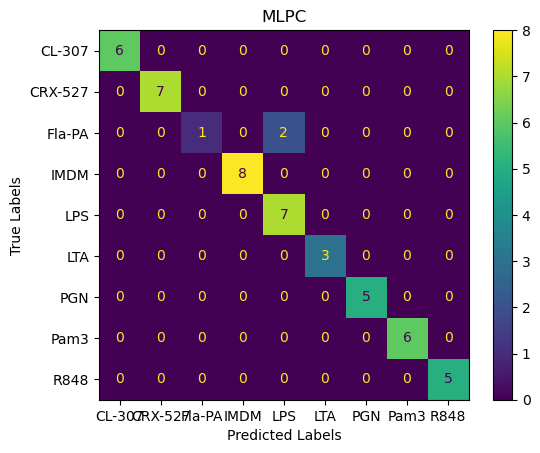

In [ ]:
for model, model_stats in statistics_dict.items():
    print(f"Model: {model}")
    for metric, value in model_stats.items():
        print(f"{metric}: {value}")

    # class_labels = y.unique()
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=statistics_dict[model]["Confusion Matrix"],
        display_labels=mlpc.classes_,
    )

cm_display.plot()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"{model}")
plt.show()